In [ ]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
import tensorflow as tf
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11047625869561360431
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14328594432
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14050801429029406948
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name)>0:
    print(f'GPU has been found... device name is{device_name}')
else:
    print('No GPU has been found...')

GPU has been found... device name is/device:GPU:0


In [ ]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [ ]:
#load data(sometimes need to use "/")
#df = pd.read_csv('D:/pythonData/python_demo_data/Stress.csv')
# Colab
df = pd.read_csv('/content/drive/MyDrive/DNN/GOLD.csv')
df

,Date,Y
0,2020/5/27,23.920000
1,2020/5/28,23.950001
2,2020/5/29,24.000000
3,2020/6/1,24.780001
4,2020/6/2,23.950001
...,...,...
752,2023/5/22,17.790001
753,2023/5/23,17.750000
754,2023/5/24,17.480000
755,2023/5/25,17.090000


# 1. Quick overview to get a grasp of the data set

In [ ]:
# 1.1 Convert date
df['Date']=pd.to_datetime(df['Date'])
df

,Date,Y
0,2020-05-27,23.920000
1,2020-05-28,23.950001
2,2020-05-29,24.000000
3,2020-06-01,24.780001
4,2020-06-02,23.950001
...,...,...
752,2023-05-22,17.790001
753,2023-05-23,17.750000
754,2023-05-24,17.480000
755,2023-05-25,17.090000


In [ ]:
new_df=df.iloc[:,[0,1]].copy()
new_df.head()

,Date,Y
0,2020-05-27,23.920000
1,2020-05-28,23.950001
2,2020-05-29,24.000000
3,2020-06-01,24.780001
4,2020-06-02,23.950001


In [ ]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
df.describe()#統計呈現

,Y
count,757.000000
mean,20.931361
std,3.885816
min,13.100000
25%,18.370001
50%,20.240000
75%,23.580000
max,30.459999


In [ ]:
# Create 3 lags
#做3個time_lag出來 有NaN是因為時間序列裡未發生的事情不能做為資料來分析
new_df['Lag_1']=new_df['Y'].shift(1).copy()
new_df['Lag_2']=new_df['Y'].shift(2).copy()
new_df['Lag_3']=new_df['Y'].shift(3).copy()
new_df.head()

,Date,Y,Lag_1,Lag_2,Lag_3
0,2020-05-27,23.920000,NaN,NaN,NaN
1,2020-05-28,23.950001,23.920000,NaN,NaN
2,2020-05-29,24.000000,23.950001,23.920000,NaN
3,2020-06-01,24.780001,24.000000,23.950001,23.920000
4,2020-06-02,23.950001,24.780001,24.000000,23.950001


In [ ]:
# Drop out missing values and rest index
#解決辦法為把資料整筆刪掉
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Y,Lag_1,Lag_2,Lag_3
0,2020-06-01,24.780001,24.000000,23.950001,23.920000
1,2020-06-02,23.950001,24.780001,24.000000,23.950001
2,2020-06-03,23.219999,23.950001,24.780001,24.000000
3,2020-06-04,23.430000,23.219999,23.950001,24.780001
4,2020-06-05,23.290001,23.430000,23.219999,23.950001
...,...,...,...,...,...
749,2023-05-22,17.790001,17.860001,17.809999,18.430000
750,2023-05-23,17.750000,17.790001,17.860001,17.809999
751,2023-05-24,17.480000,17.750000,17.790001,17.860001
752,2023-05-25,17.090000,17.480000,17.750000,17.790001


In [ ]:
# Train data
Forecast_train_data=clean_df.iloc[0:646,:].copy()
Forecast_train_data

,Date,Y,Lag_1,Lag_2,Lag_3
0,2020-06-01,24.780001,24.000000,23.950001,23.920000
1,2020-06-02,23.950001,24.780001,24.000000,23.950001
2,2020-06-03,23.219999,23.950001,24.780001,24.000000
3,2020-06-04,23.430000,23.219999,23.950001,24.780001
4,2020-06-05,23.290001,23.430000,23.219999,23.950001
...,...,...,...,...,...
641,2022-12-14,17.389999,17.440001,16.730000,16.580000
642,2022-12-15,16.650000,17.389999,17.440001,16.730000
643,2022-12-16,16.900000,16.650000,17.389999,17.440001
644,2022-12-19,16.549999,16.900000,16.650000,17.389999


In [ ]:
# Test data
Forecast_test_data=clean_df.iloc[646:646+108,:].copy()
Forecast_test_data

,Date,Y,Lag_1,Lag_2,Lag_3
646,2022-12-21,17.500000,17.280001,16.549999,16.900000
647,2022-12-22,17.299999,17.500000,17.280001,16.549999
648,2022-12-23,17.389999,17.299999,17.500000,17.280001
649,2022-12-27,17.770000,17.389999,17.299999,17.500000
650,2022-12-28,17.209999,17.770000,17.389999,17.299999
...,...,...,...,...,...
749,2023-05-22,17.790001,17.860001,17.809999,18.430000
750,2023-05-23,17.750000,17.790001,17.860001,17.809999
751,2023-05-24,17.480000,17.750000,17.790001,17.860001
752,2023-05-25,17.090000,17.480000,17.750000,17.790001


In [ ]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:322,:].copy()
Rol_val_1=Forecast_train_data.iloc[322:322+108,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[106:430,:].copy()
Rol_val_2=Forecast_train_data.iloc[430:430+108,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[217:538,:].copy()
Rol_val_3=Forecast_train_data.iloc[538:538+108,:].copy()

In [ ]:
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_1.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_1['Y'].copy()
y_val=Rol_val_1['Y'].copy()

In [ ]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.452078,0.447837,0.445293
1,0.518236,0.452078,0.447837
2,0.447837,0.518236,0.452078
3,0.385920,0.447837,0.518236
4,0.403732,0.385920,0.447837


In [ ]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


In [ ]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

# Sequential style coding for creating net

Note: The following code demonstrate the most common style for creating net

In [ ]:
# Some self define functions for building deep neural networks
def dense_generator(model_name,layers,last_layer_neurons,activation_fun='elu'):
    n=last_layer_neurons
    neurons=n
    for i in range(0,layers):
        neurons=neurons*2
        model_name.add(Dense(units=neurons, activation=activation_fun))
        if(i%5==0):
          model.add(Dropout(rate=0.3))

In [ ]:
# with tf.device(device_name):
# Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

dense_generator(model,11,6)


model.add(Dense(units=1, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.001,beta_1=0.9)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 96)                4704      
                                                                 
 dense_5 (Dense)             (None, 192)               1

Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model

# Note: The validation set should be split manually

In [ ]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=24)

# 7.1 Store in the history for more useful information
history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
5/5 [==============================] - 0s 51ms/step - loss: 3.9869 - mean_absolute_percentage_error: 15.5285 - val_loss: 2.7396 - val_mean_absolute_percentage_error: 11.3749
Epoch 2/100
5/5 [==============================] - 0s 40ms/step - loss: 2.8545 - mean_absolute_percentage_error: 12.2436 - val_loss: 3.5623 - val_mean_absolute_percentage_error: 13.4167
Epoch 3/100
5/5 [==============================] - 0s 36ms/step - loss: 3.5983 - mean_absolute_percentage_error: 13.9054 - val_loss: 3.3500 - val_mean_absolute_percentage_error: 14.7889
Epoch 4/100
5/5 [==============================] - 0s 38ms/step - loss: 5.1544 - mean_absolute_percentage_error: 23.4667 - val_loss: 2.6522 - val_mean_absolute_percentage_error: 10.5480
Epoch 5/100
5/5 [==============================] - 0s 36ms/step - loss: 4.0792 - mean_absolute_percentage_error: 16.0613 - val_loss: 2.6576 - val_mean_absolute_percentage_error: 10.5027
Epoch 6/100
5/5 [==============================] - 0s 43ms/step - loss

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

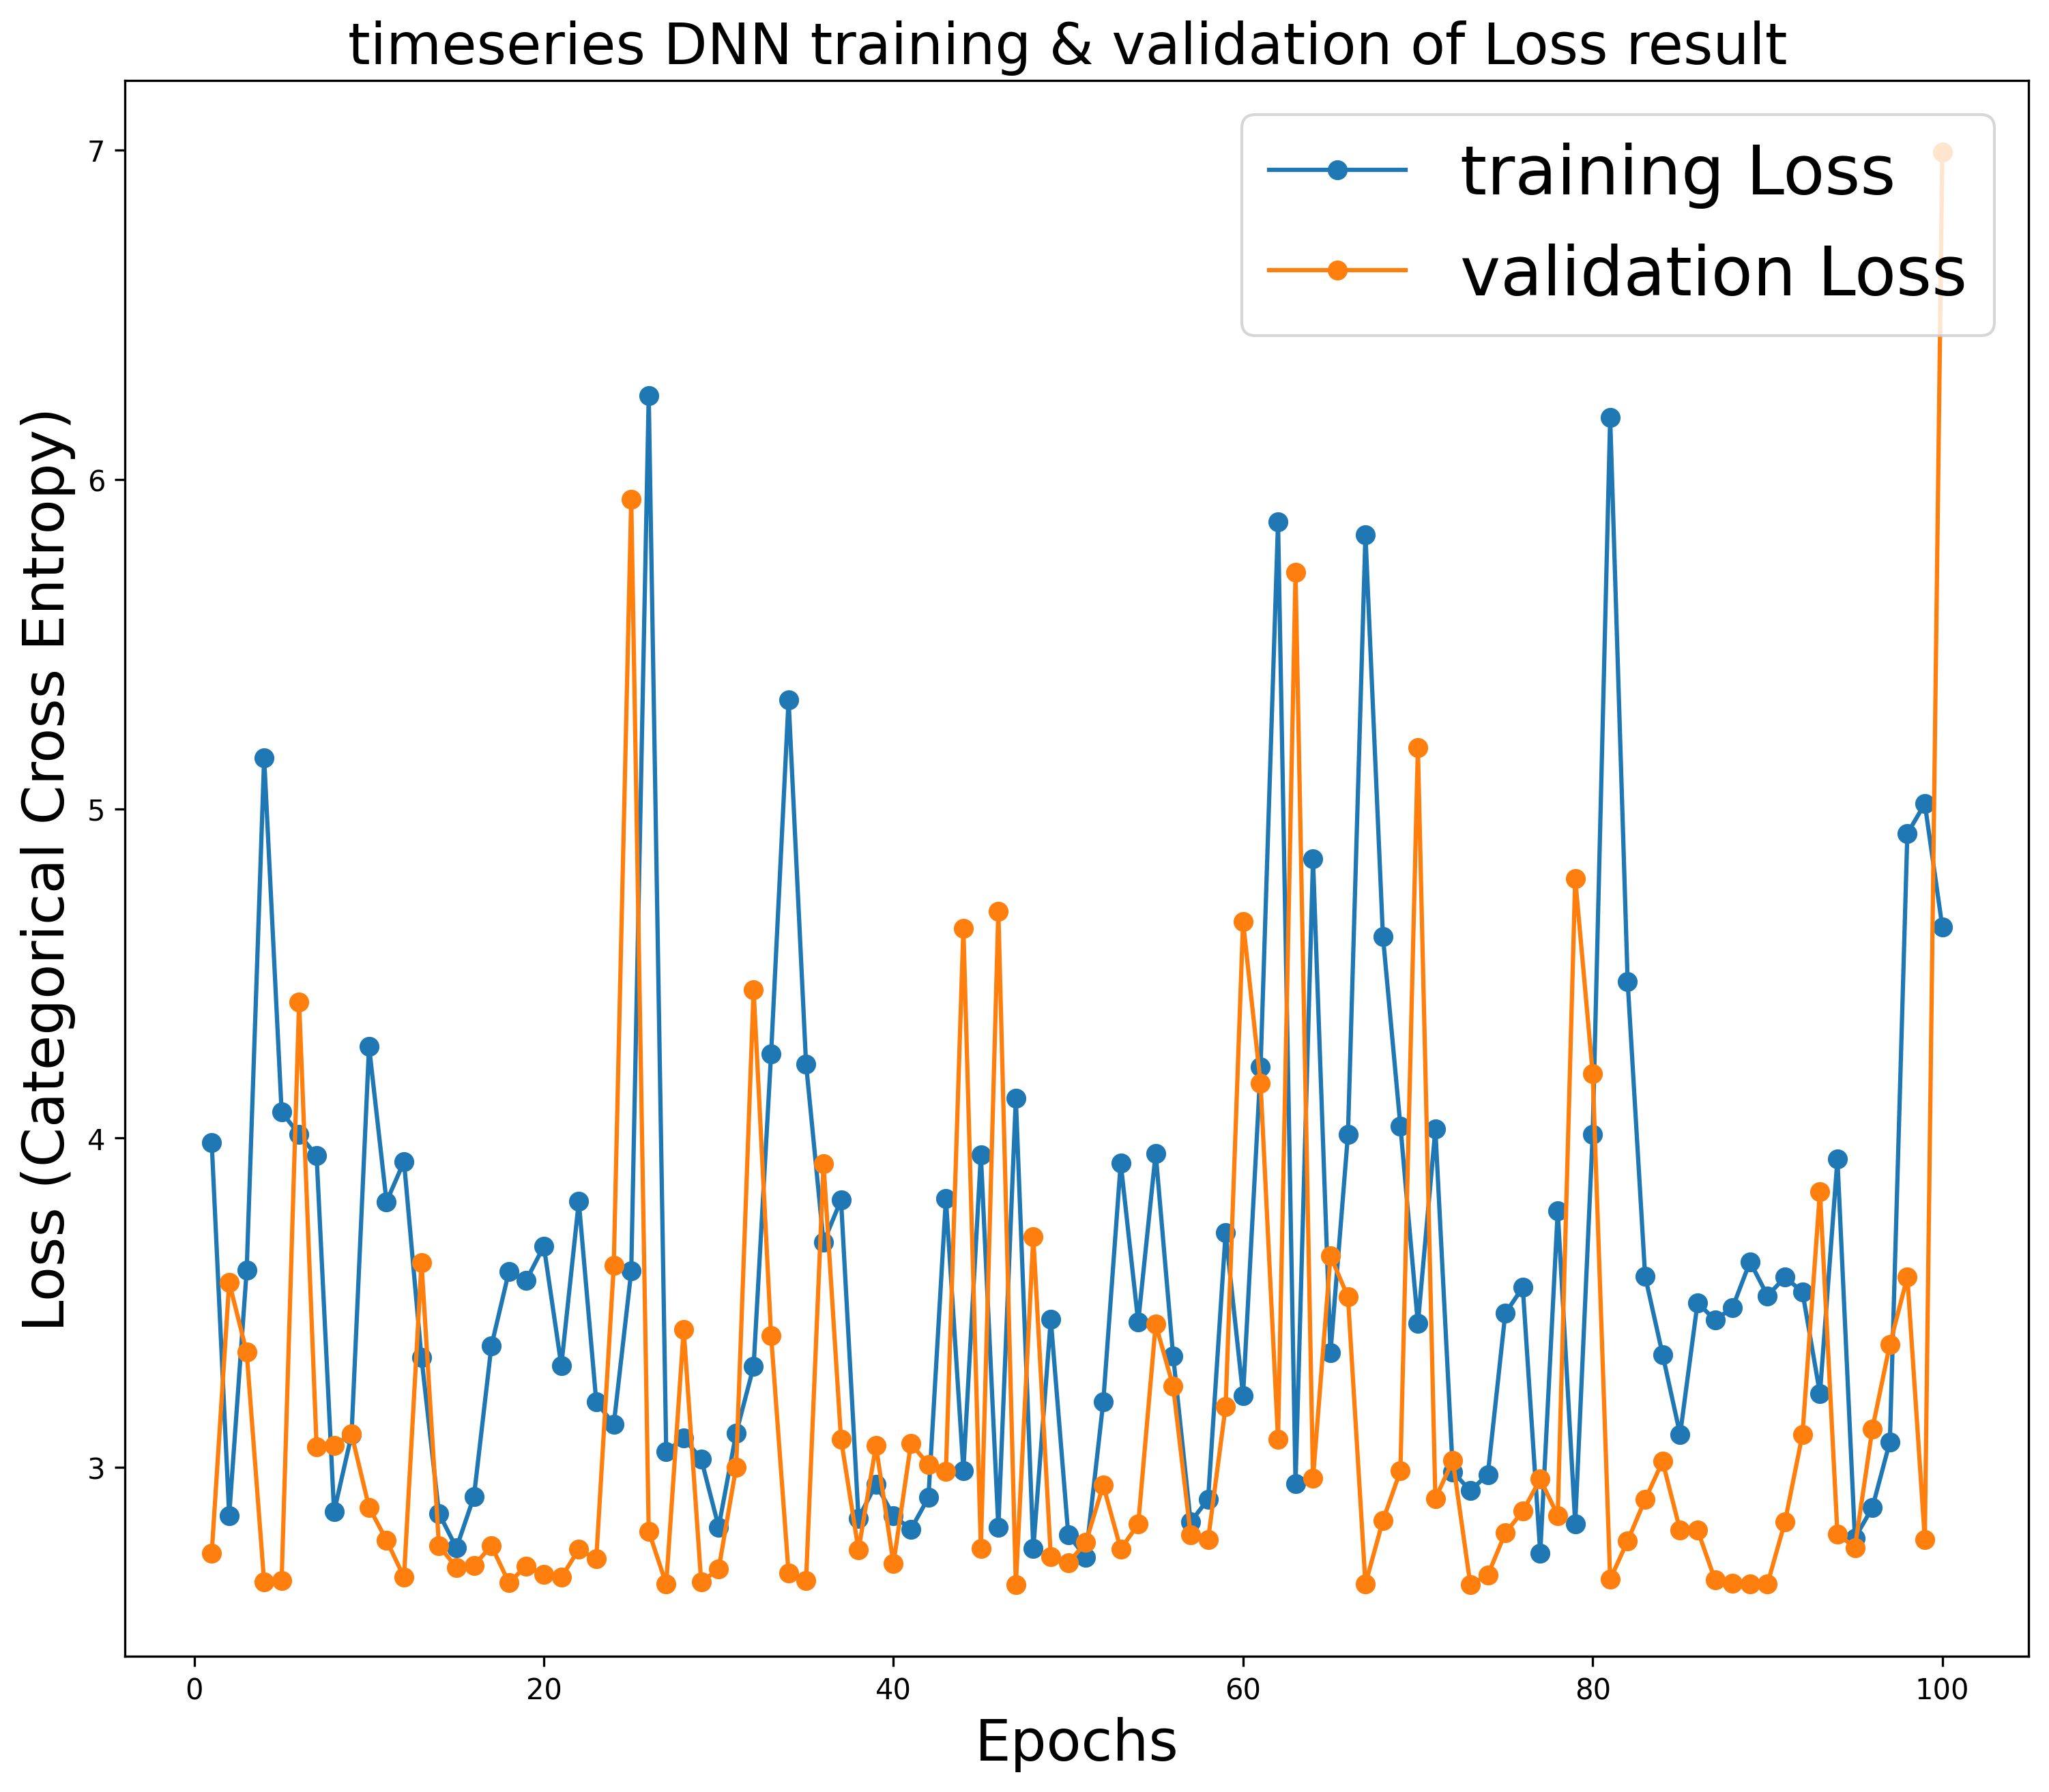

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('timeseries DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

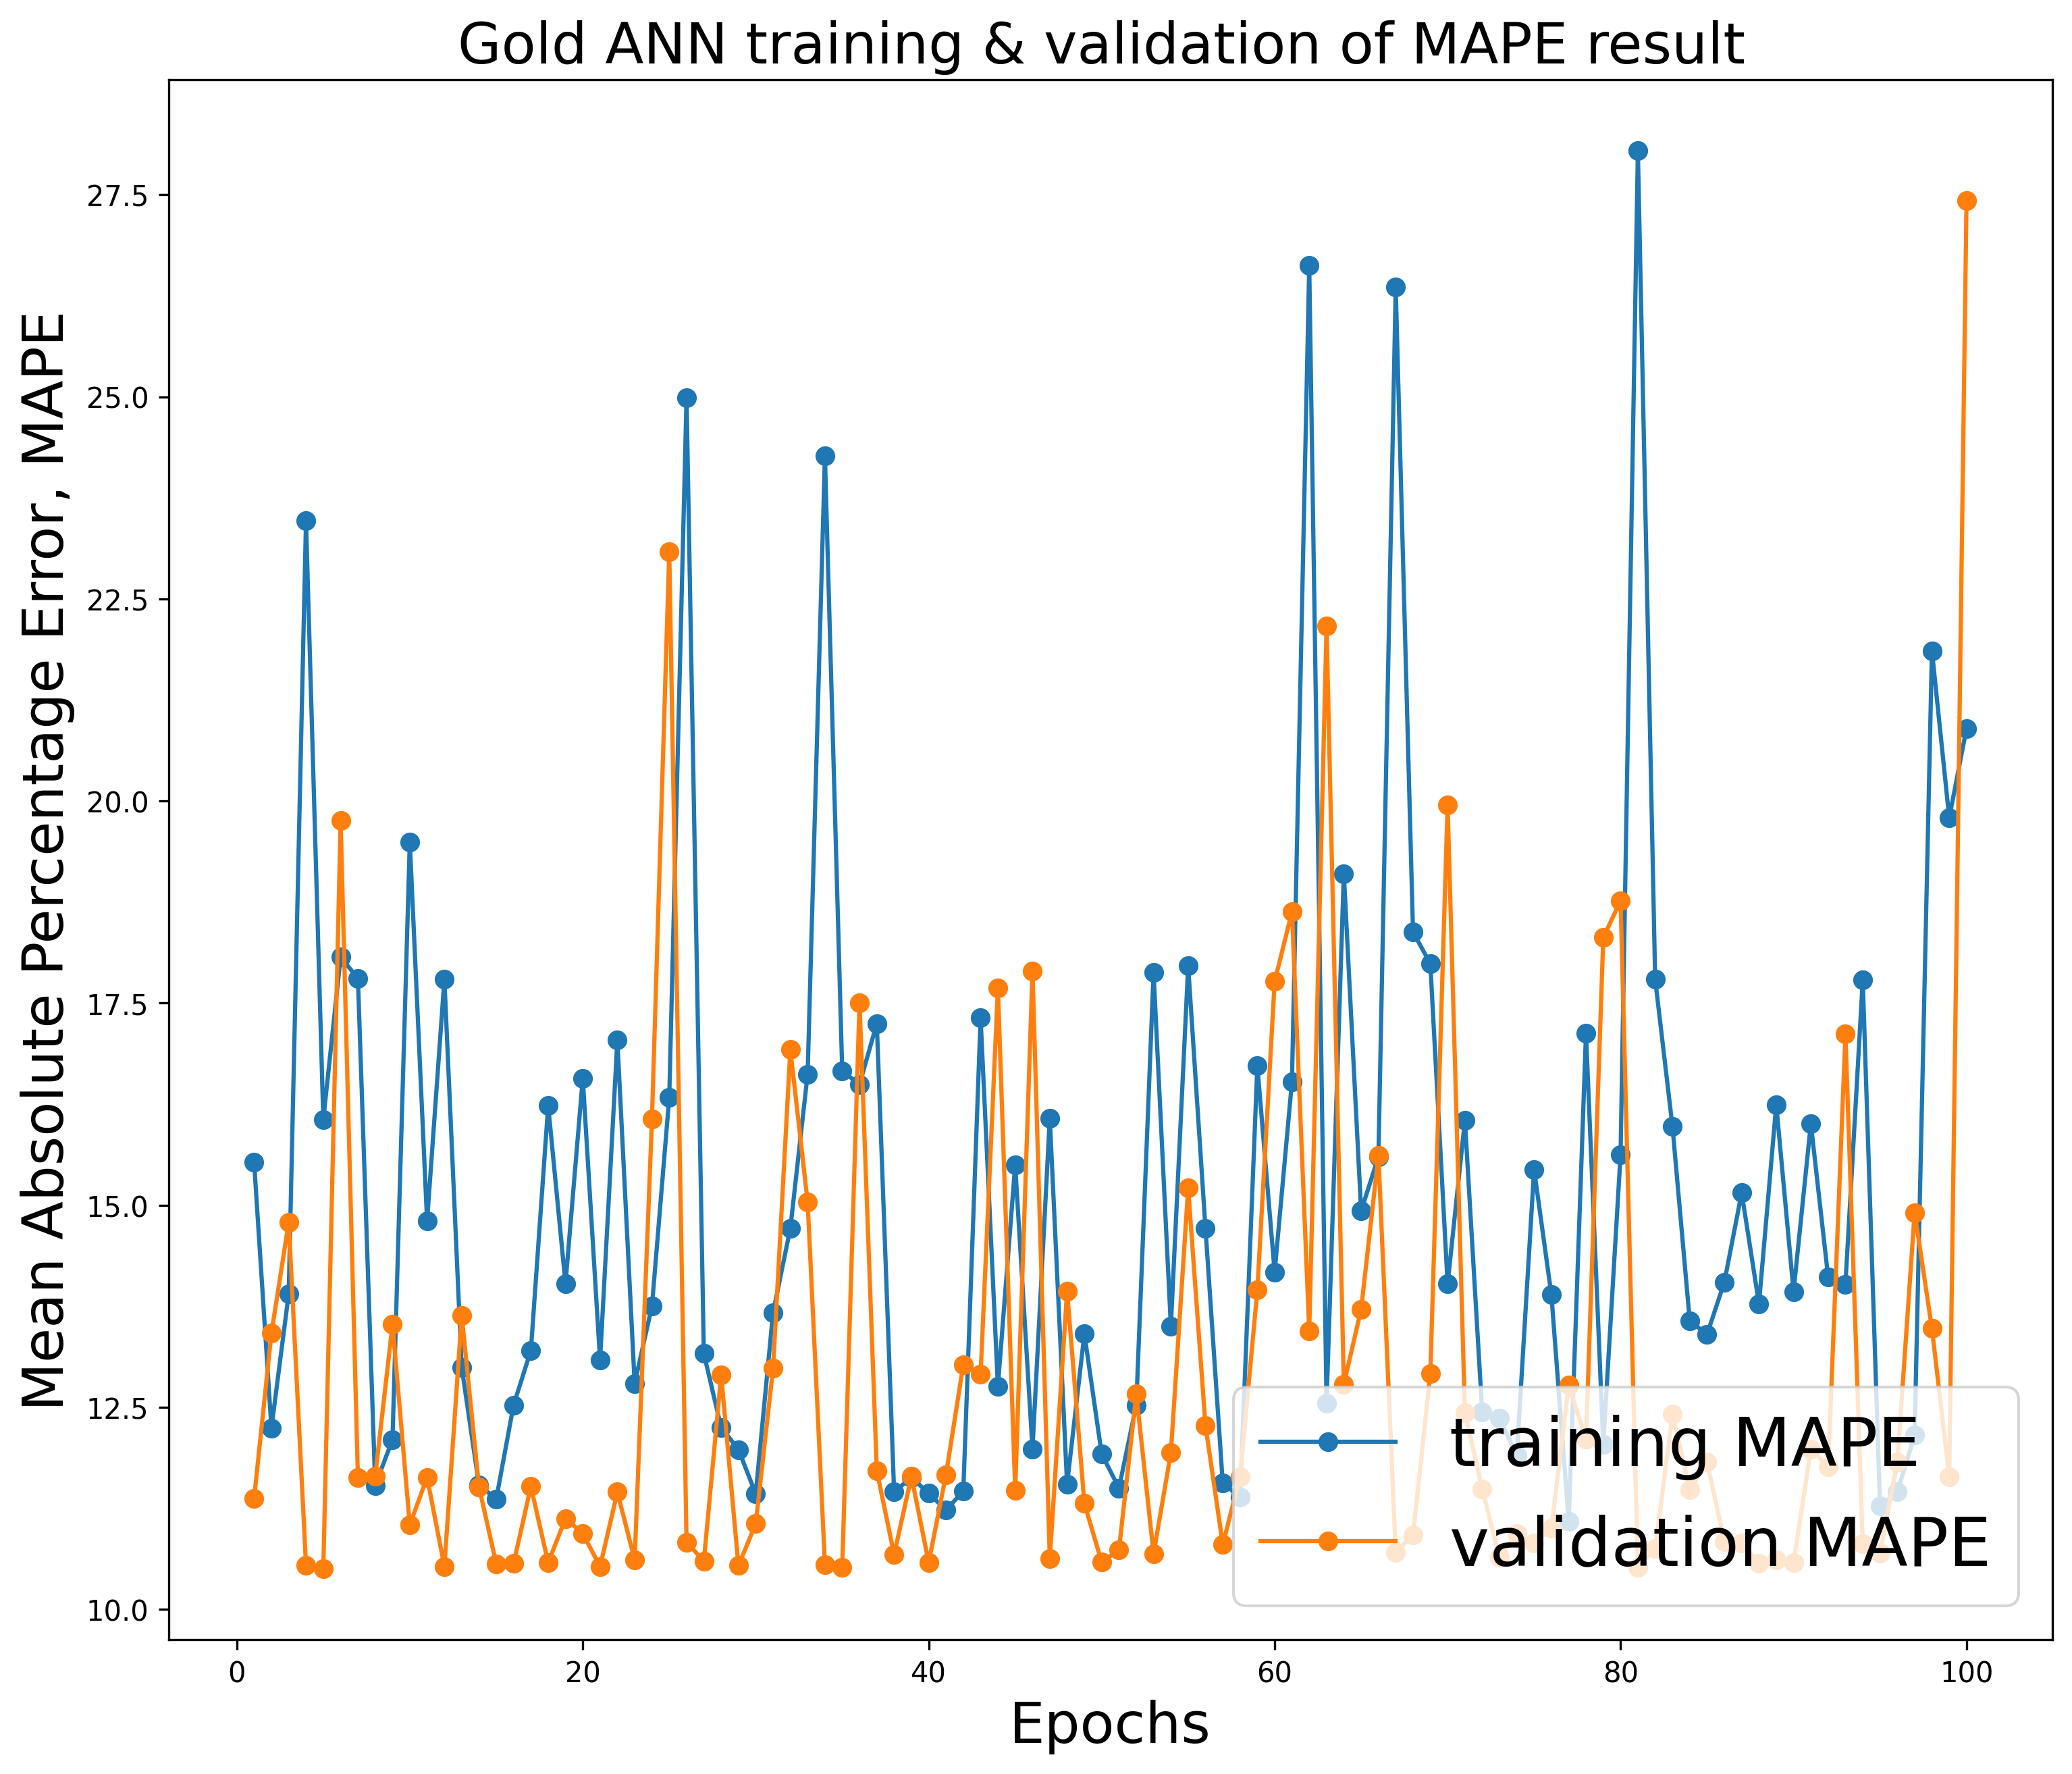

In [ ]:
# 7.2 Plot the history of training and validation

training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Gold ANN training & validation of MAPE result ',fontsize=20)



plt.plot(epochs, training_acc_values,marker='o',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='o',label='validation MAPE')
plt.legend(loc=4,fontsize=24)
plt.show()

In [ ]:
# 7.3 Save the trained model
#model.save('D:/data_analysis/PyExport/Multiclass_ANN_trained_model.h5')
# Colab
model.save('/content/drive/MyDrive/DNN/timeseries_DNN_trained_model_e03.h5')
print('Model has been saved...')

Model has been saved...


In [ ]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Multiclass_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('/content/drive/MyDrive/DNN/timeseries_DNN_trained_model_e03.h5')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [ ]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Y'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Y'].copy()

In [ ]:
# 8.1 Make prediction 
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [ ]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Y'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
646,2022-12-21,17.500000,17.750000,0.250000
647,2022-12-22,17.299999,17.750000,0.450001
648,2022-12-23,17.389999,17.670000,0.280001
649,2022-12-27,17.770000,17.680000,0.090000
650,2022-12-28,17.209999,17.719999,0.510000
...,...,...,...,...
749,2023-05-22,17.790001,17.629999,0.160002
750,2023-05-23,17.750000,17.660000,0.090000
751,2023-05-24,17.480000,17.650000,0.170000
752,2023-05-25,17.090000,17.639999,0.549999


In [ ]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 1.252
MSE: 2.049
RMSE: 1.432
MAPE: 6.755 %
SMAPE: 6.913 %
RAE: 1.213
MRAE: 0.011235899094263964
MdRAE: 1.523 bench: 18.332
RSE: 1.373
RRSE: 1.172


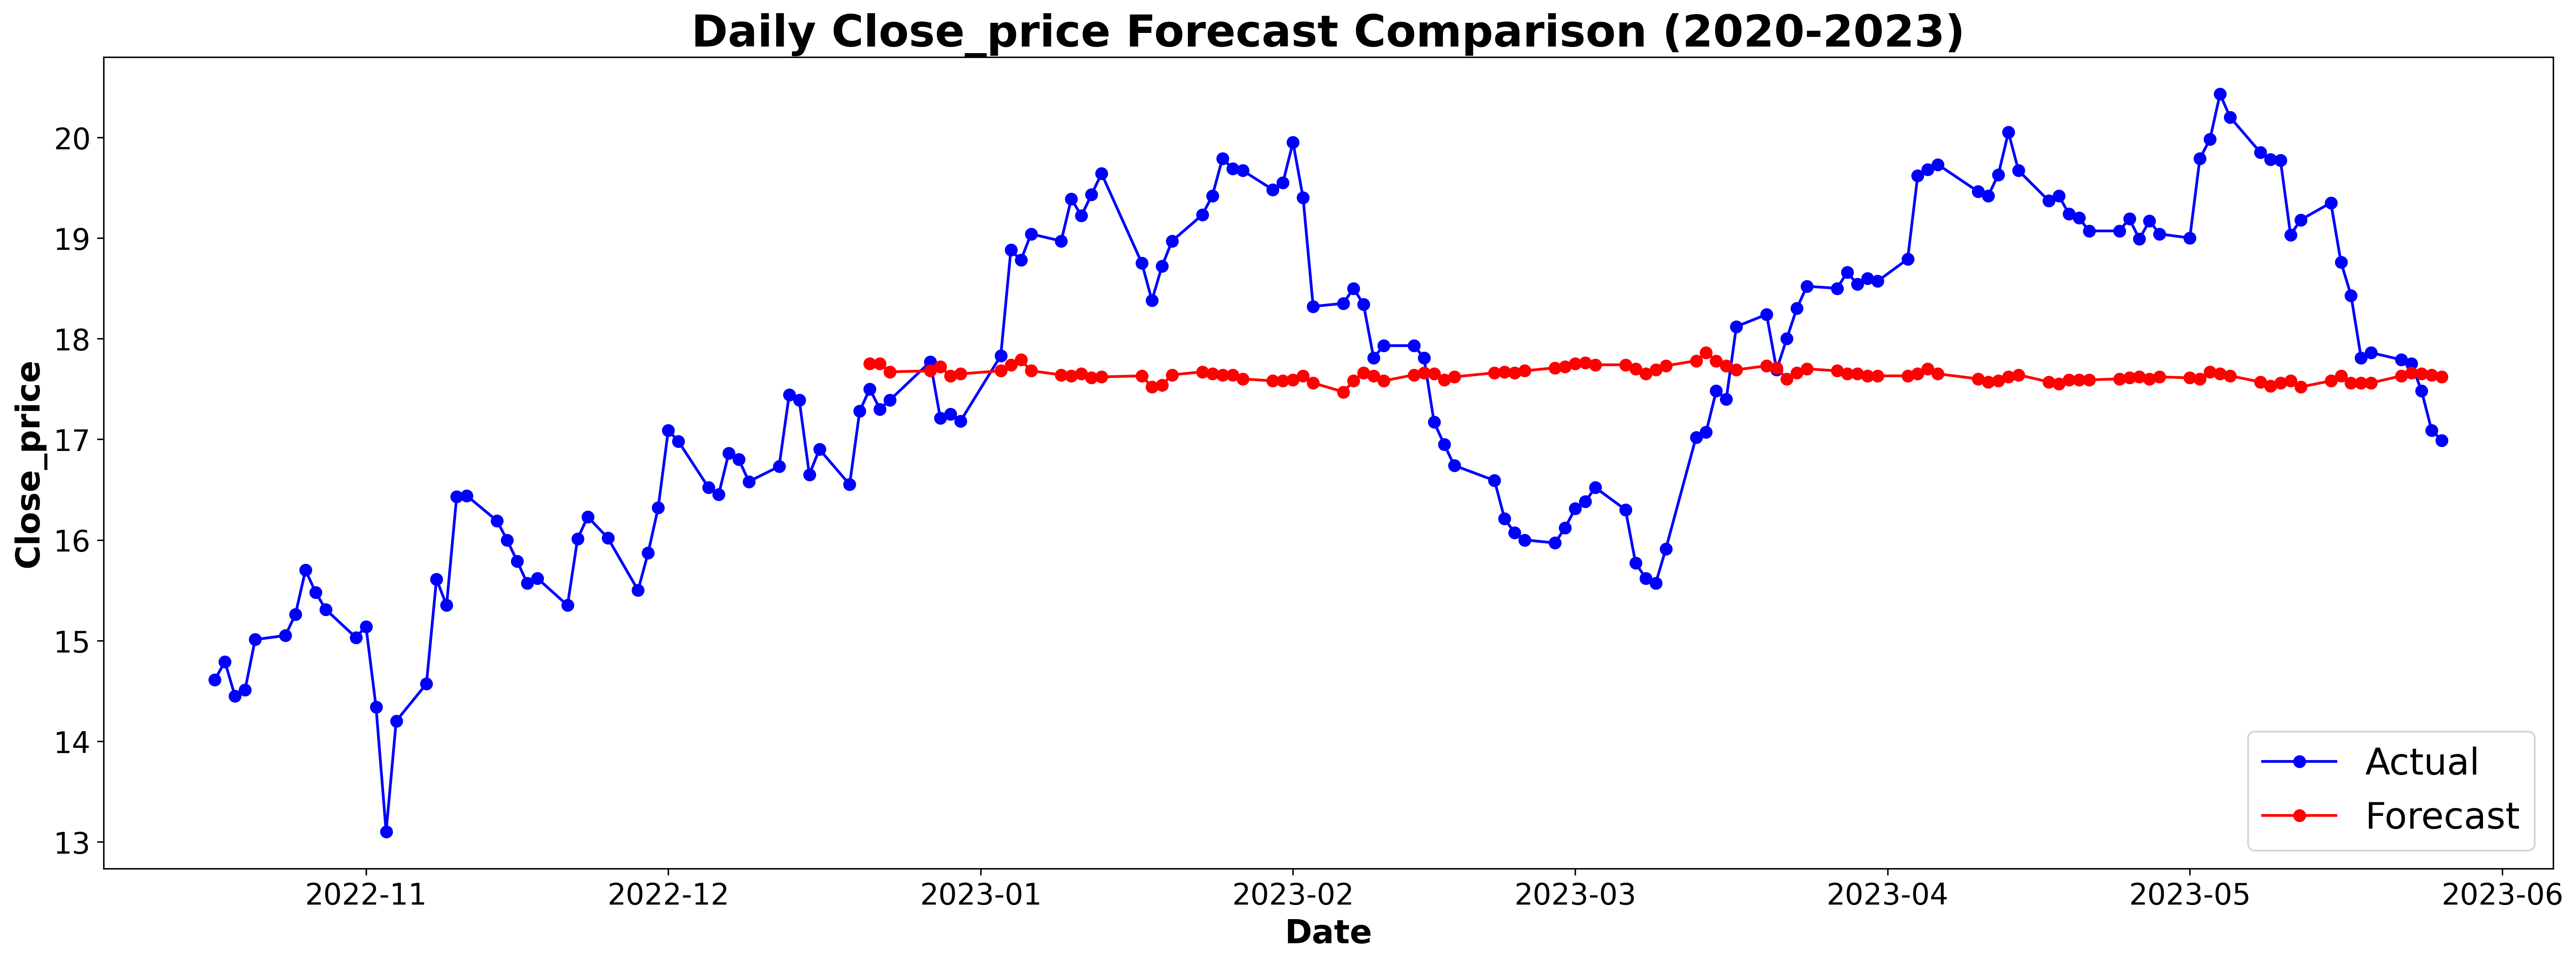

In [ ]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Daily Close_price Forecast Comparison (2020-2023)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close_price',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[600:,0],clean_df.iloc[600:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()